In [ ]:
 !pip install rarfile


Define the paths we are going to use

In [ ]:

sqlite_path = f'/content/drive/MyDrive/Data_Mining/Project/ATAC-Final.sqlite'
assets_path = f'/content/drive/MyDrive/Data_Mining/Project/Assets'

Import code shared with the parser

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from bs4 import BeautifulSoup
from os import listdir
from os.path import join
from datetime import datetime
import re
import rarfile
from os import mkdir, remove, listdir, walk
from os.path import join, exists
from tqdm.notebook import tqdm 

from sqlalchemy import create_engine, Column, Integer, String, DateTime, Boolean, ForeignKey, Date
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import func
from sqlalchemy.orm import relationship
engine = create_engine('sqlite:///'+sqlite_path, echo=False)
Base = declarative_base()

class RouteStop(Base):
  __tablename__ = 'routestops'
  route_id = Column(Integer, nullable=False, primary_key= True)
  stop_id = Column(Integer, nullable=False, primary_key= True)
  line_id = Column(String)
  name = Column(String, nullable=False)
  position = Column(Integer, nullable=False)
  last = Column(Boolean, nullable=False, default=False) # TODO not implemented

  # buses = relationship("BusLocation", foreign_keys=[route_id, stop_id])

  def __str__(self):
    return f"[{self.position}@{self.route_id} | {self.name}({self.stop_id}) ]"
  

class BusLocation(Base):
  __tablename__ = 'buslocations'
  
  time = Column(DateTime, nullable=False, primary_key= True)
  bus_id = Column(Integer, nullable=False, primary_key= True)
  route_id = Column(Integer, ForeignKey('routestops.route_id'))
  stop_id = Column(Integer, ForeignKey('routestops.stop_id'))

  stop = relationship("RouteStop",
                    primaryjoin="and_(BusLocation.route_id==RouteStop.route_id, "
                        "BusLocation.stop_id==RouteStop.stop_id)")


  def __str__(self):
    return f"{self.time.hour}:{self.time.minute} [{self.bus_id}]  @  {self.stop_id} - {self.route_id} {self.stop}"

class RouteStopState(Base):
   __tablename__ = 'routestopdelays'

   stop_id = Column(Integer, ForeignKey('routestops.stop_id'),primary_key= True)
   route_id = Column(Integer, ForeignKey('routestops.route_id'),primary_key= True)
   time = Column(DateTime, nullable=False, primary_key= True)
   state = Column(Integer)

class RouteDeparture(Base):
  __tablename__ = 'routedepartures'
  route_id = Column(Integer, ForeignKey('routestops.route_id'),primary_key= True)
  time = Column(DateTime, nullable=False, primary_key= True)
  day = Column(Date )
   

Base.metadata.create_all(engine)

from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=engine)
session = Session()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Additional imports to work with data

In [ ]:
from sqlalchemy import distinct, func
from sqlalchemy.orm import aliased
import matplotlib
from matplotlib import pyplot as plt
from random import choice

Queries to retrieve arrays of (day, feat)

In [ ]:
session.rollback()

def bus_stops_to_average(stops):
  p2, t2 = stops.pop(0)
  stops_num = 0
  time = 0.0000000001
  avg = 0 

  for s in stops:
    p1, t1 = (p2,t2)
    p2, t2 = s


    if p1 < p2 :
      stops_num += (p2-p1)
      time += (t2-t1).seconds/ (60*10)
      avg = stops_num/( time)

  return avg, stops_num, time

from datetime import timedelta
def bus_stops_runs_count(stops):
  p2, t2 = stops.pop(0)
  runs = 1

  for s in stops:
    p1, t1 = (p2,t2)
    p2, t2 = s

    if p1 > p2 :
      runs += 1
  

  return runs
def get_avg_lateness(route_id):
  
  days = session.query(BusLocation.time).group_by(func.date(BusLocation.time)).filter(BusLocation.route_id == f'{route_id}').order_by(BusLocation.time).all()
  days = [ d[0].date() for d in days ]

  avg_array = []
  for d in tqdm(days):
    tot_stops_num = 0
    tot_time = 0.00000000001
    buses = session.query(distinct(BusLocation.bus_id)).filter(BusLocation.route_id == f'{route_id}', func.date(BusLocation.time) == d ).order_by(BusLocation.time).all()
    buses = [ b[0] for b in buses]
    for b in (buses):
      stops = session.query( RouteStop.position, BusLocation.time)\
        .filter( BusLocation.stop_id == RouteStop.stop_id) \
        .filter(BusLocation.route_id == RouteStop.route_id)\
        .filter(BusLocation.route_id == f'{route_id}', BusLocation.bus_id == b)\
        .order_by(BusLocation.time).all()

      
      

      stops = [ (s[0], s[1]) for s in stops]
      avg, stops_num, time = bus_stops_to_average(stops)
      tot_stops_num += stops_num
      tot_time += time

    avg_array.append ( (d, tot_stops_num/tot_time) )
  return avg_array

def get_daily_runs(route_id):
  
  days = session.query(distinct(func.date(BusLocation.time))).filter(BusLocation.route_id == f'{route_id}').order_by(BusLocation.time).all()
  days = [ d[0] for d in days ]

  runs_array = []
  for d in tqdm(days):
    runs = 0
    
    buses = session.query(distinct(BusLocation.bus_id)).filter(BusLocation.route_id == f'{route_id}', func.date(BusLocation.time) == d ).order_by(BusLocation.time).all()
    buses = [ b[0] for b in buses]
    for b in (buses):
      stops = session.query( RouteStop.position, BusLocation.time)\
        .filter( BusLocation.stop_id == RouteStop.stop_id) \
        .filter(BusLocation.route_id == RouteStop.route_id)\
        .filter(BusLocation.route_id == f'{route_id}', BusLocation.bus_id == b, func.date(BusLocation.time) == d)\
        .order_by(BusLocation.time).all()

      if stops:

        stops = [ (s[0], s[1]) for s in stops]
        runs += bus_stops_runs_count(stops)


    runs_array.append ( (d, runs) )
  return runs_array



def get_avg_traffic(route_id):
  
  days = session.query(BusLocation.time).group_by(func.date(BusLocation.time)).filter(BusLocation.route_id == f'{route_id}').order_by(BusLocation.time).all()
  days = [ d[0].date() for d in days ]

  res = []
  for d in tqdm(days):
    states = session.query(RouteStopState.state, func.count('*'))\
        .filter(RouteStopState.route_id == f'{route_id}', func.date(RouteStopState.time) == d )\
        .group_by(RouteStopState.state).all()
    res.append((d, *states))
  return res




Code to plot the graph for real vs declared departures

In [ ]:
%matplotlib inline
from random import choice
import numpy as np
session.rollback()


def plot_departures(line_id, route_id, save=False):
  actual_runs = get_daily_runs((route_id))
  sched_runs = session.query(func.count(RouteDeparture.time),RouteDeparture.day).filter(RouteDeparture.route_id == route_id).group_by(RouteDeparture.day).all()

  y1_dic = {s[1]: s[0] for s in sched_runs }
  y2_dic = {datetime.strptime(xi, "%Y-%m-%d" ).date():yi for xi,yi in actual_runs }

  y_tot = []
  x_tot = []
  for x in sorted(list(set(y1_dic.keys()).union(set(y2_dic.keys())))):
    y_tot.append((y1_dic.get(x,0), y2_dic.get(x,0)))
    x_tot.append(x)

  _, ax = plt.subplots(1,1,figsize=(30,5))


  x_nums = np.arange(len(x_tot))  
  y1, y2 = zip(*y_tot)
  ax.bar(x_tot , y1, 0.5, label =  'Scheduled Departures', color='white', edgecolor='black')
  ax.bar(x_tot , y2, 0.5, label =  'Actual Departures', color='red', alpha=0.6)
  ax.legend()
  ax.set_title( f'Expected vs Actual Departures on route:{route_id} @ line:{line_id}')
  ax.set_ylabel('Departures')
  ax.set_xlabel('Day')
  ax.axvline(datetime(year=2020, month=3, day=9),0,0.8, c='black', label='Lockdown begins' )
  ax.axvline(datetime(year=2020, month=5, day=4),0,0.8, c='black', label='Lockdown eased' )
  ax.axvline(datetime(year=2020, month=5, day=18),0,0.8, c='black', label='Lockdown ends' )

  ah = int( max(max(y1), max(y2))*0.8)
  plt.annotate('Lockdown \n begins', (datetime(year=2020, month=3, day=9),ah))
  plt.annotate('Lockdown \n eased', (datetime(year=2020, month=5, day=4),ah))
  plt.annotate('Lockdown \n ends', (datetime(year=2020, month=5, day=18),ah))
  if save:
    plt.savefig(join(assets_path,f'Departures-{line_id}r{route_id}' ) )
    plt.show()




Code to plot average and peak buses per crawl

In [ ]:
%matplotlib inline
from random import choice
import numpy as np
session.rollback()


def plot_avg_buses(line_id, route_id, save=False):
  actual_runs = get_daily_runs((route_id))
  
  sub_q = session.query(BusLocation.time,func.count('*').label('count')).filter(BusLocation.route_id == route_id).group_by(BusLocation.time).subquery()
  avg_buses_day = session.query(sub_q.c.time, func.max(sub_q.c.count)).group_by(func.date(sub_q.c.time)).all()


  avg_buses_crawl = session.query(sub_q.c.time, func.avg(sub_q.c.count)).group_by(func.date(sub_q.c.time)).all()


  y1_dic = {xi.date():yi for xi,yi in avg_buses_day }
  y2_dic = {xi.date():yi for xi,yi in avg_buses_crawl }

  y_tot = []
  x_tot = []
  for x in sorted(list(set(y1_dic.keys()).union(set(y2_dic.keys())))):
    y_tot.append((y1_dic.get(x,0), y2_dic.get(x,0)))
    x_tot.append(x)

  _, ax = plt.subplots(1,1,figsize=(30,5))


  x_nums = np.arange(len(x_tot))  
  y1, y2 = zip(*y_tot)
  ax.bar(x_tot , y2, 0.5, label =  'Average Buses on Route', color='red', alpha=0.8)
  ax.bar(x_tot , y1, 0.5, label =  'Peak Buses on Route Departures', color='grey', edgecolor='black', alpha=0.4)
  
  ax.legend()
  ax.set_title( f'Peak and Average of Buses per Crawl on route:{route_id} @ line:{line_id}')
  ax.set_ylabel('BusesCount')
  ax.set_xlabel('Day')


  ah = int( max(max(y1), max(y2))*0.8)
  ax.axvline(datetime(year=2020, month=3, day=9),0,0.8, c='black', label='Lockdown begins' )
  ax.axvline(datetime(year=2020, month=5, day=4),0,0.8, c='black', label='Lockdown eased' )
  ax.axvline(datetime(year=2020, month=5, day=18),0,0.8, c='black', label='Lockdown ends' )
  plt.annotate('Lockdown \n begins', (datetime(year=2020, month=3, day=9),ah))
  plt.annotate('Lockdown \n eased', (datetime(year=2020, month=5, day=4),ah))
  plt.annotate('Lockdown \n ends', (datetime(year=2020, month=5, day=18),ah))
  if save:
    plt.savefig(join(assets_path,f'BusesCount-{line_id}r{route_id}' ) )
    plt.show()


Code to plot average daily traffic

In [ ]:

def plot_avg_traffic(line_id, route_id, save=False):
  ## 
  r = get_avg_traffic(route_id)

  y = []
  x = []
  for daytuple in r:
    date= daytuple[0]
    x.append(datetime(year = 2020, month=date.month, day=date.day))
    counts = [0]*6
    for state, num in daytuple[1:]:
      if state in [0,1,2,3,4]:
        counts[state] = num
      else:
        counts[-1] = num

    y.append(counts)
  y = list(zip(*y))

  bottom = np.zeros(len(x))
  colors = [  'green', 'yellow', 'orange', 'red','white', ][::-1] +['black']

  _, ax = plt.subplots(1,1,figsize=(30,5))
  for e, yi in enumerate(y):
    y_arr = np.array(yi)
    if e == 5:
      e = -1
    ax.bar(x , y_arr, 0.5, bottom=bottom, label =  f'State {e}', color=colors[e], edgecolor='black', alpha=0.6)
    bottom  += y_arr


  ax.legend()
  ax.set_title( f'Cumulative traffic situation on route:{route_id} @ line:{line_id}')
  ax.set_ylabel('TrafficStates')
  ax.set_xlabel('Day')


  ah = int( max([max(yi) for yi in y])*0.8)
  # ax.axvline(datetime(year=2020, month=3, day=9),0,0.8, c='black', label='Lockdown begins' )
  # ax.axvline(datetime(year=2020, month=5, day=4),0,0.8, c='black', label='Lockdown eased' )
  # ax.axvline(datetime(year=2020, month=5, day=18),0,0.8, c='black', label='Lockdown ends' )
  # plt.annotate('Lockdown \n begins', (datetime(year=2020, month=3, day=9),ah))
  # plt.annotate('Lockdown \n eased', (datetime(year=2020, month=5, day=4),ah))
  # plt.annotate('Lockdown \n ends', (datetime(year=2020, month=5, day=18),ah))
  if save:
    plt.savefig(join(assets_path,f'Traffic-{line_id}r{route_id}' ) )
    plt.show()



Plot and save all the graphs

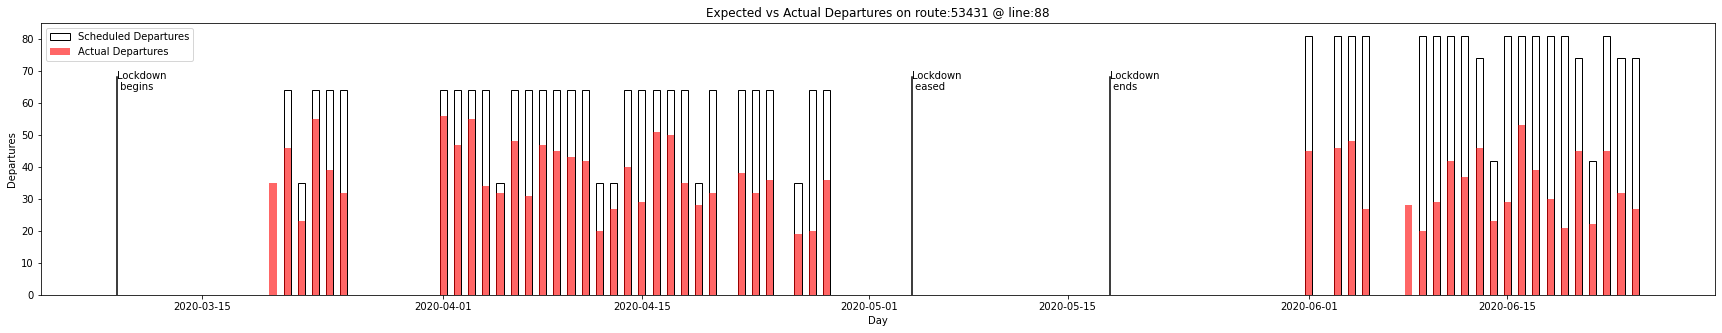

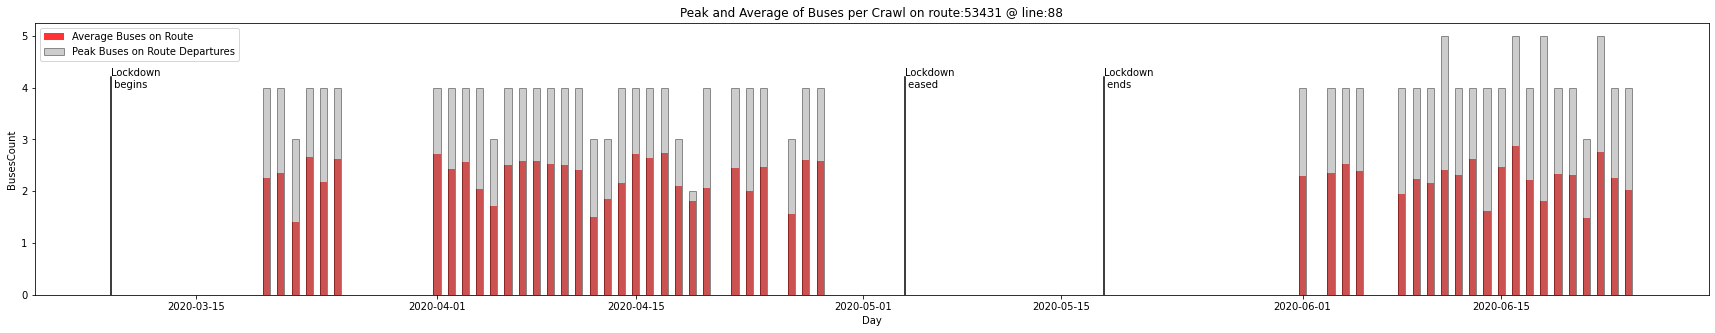

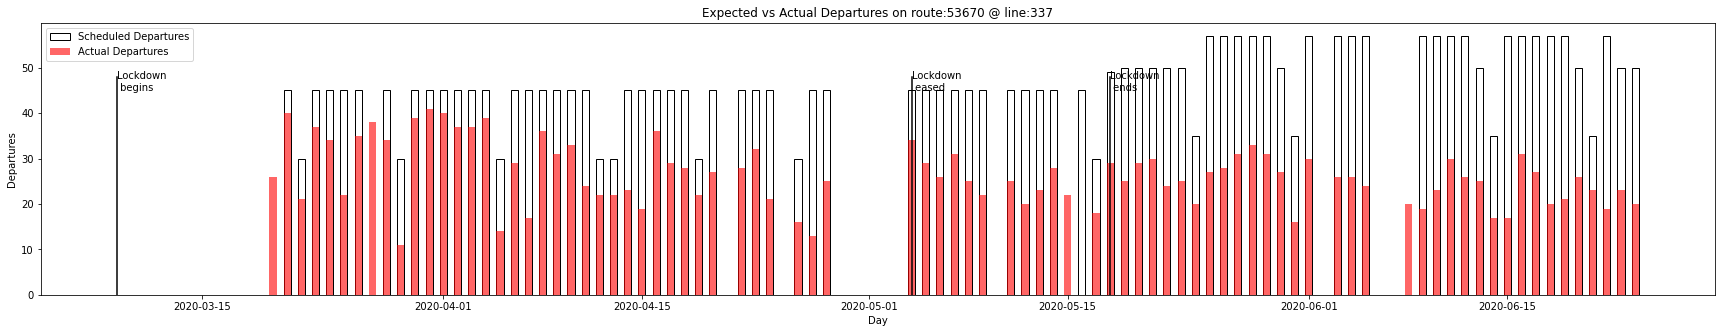

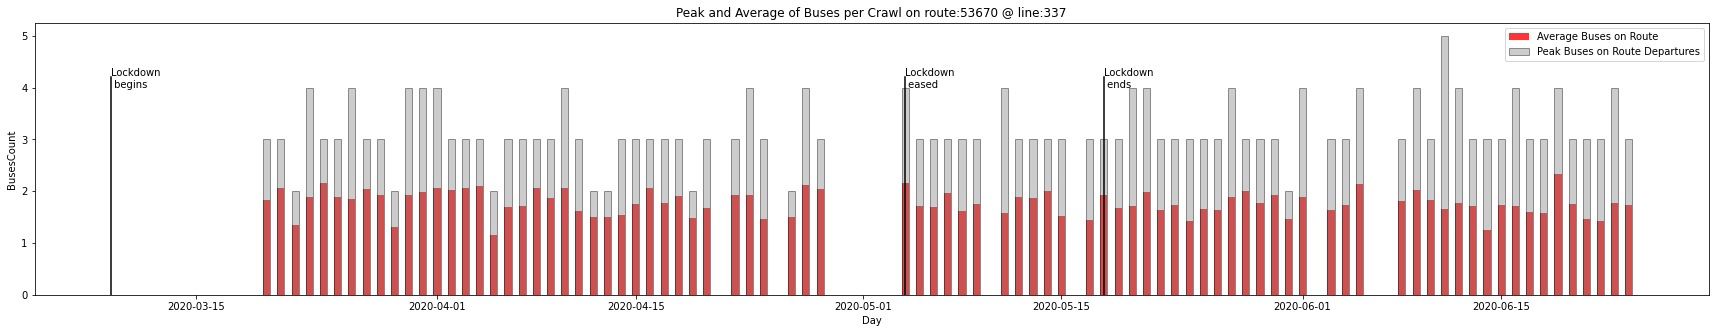

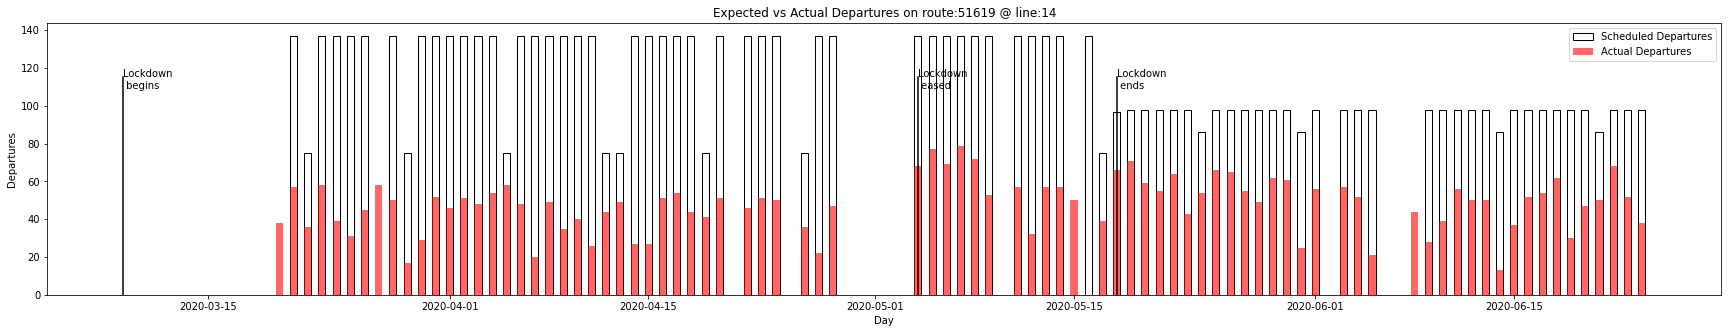

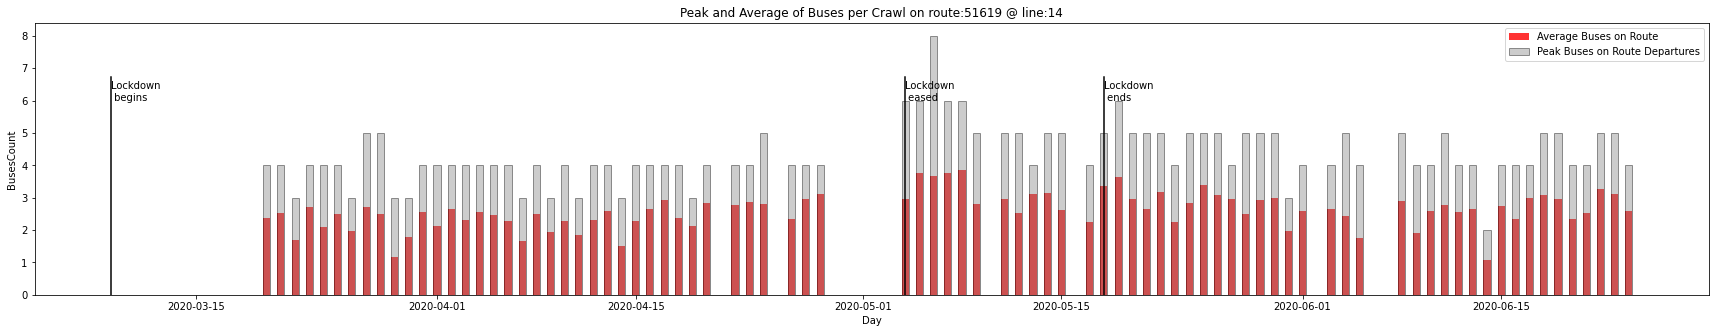

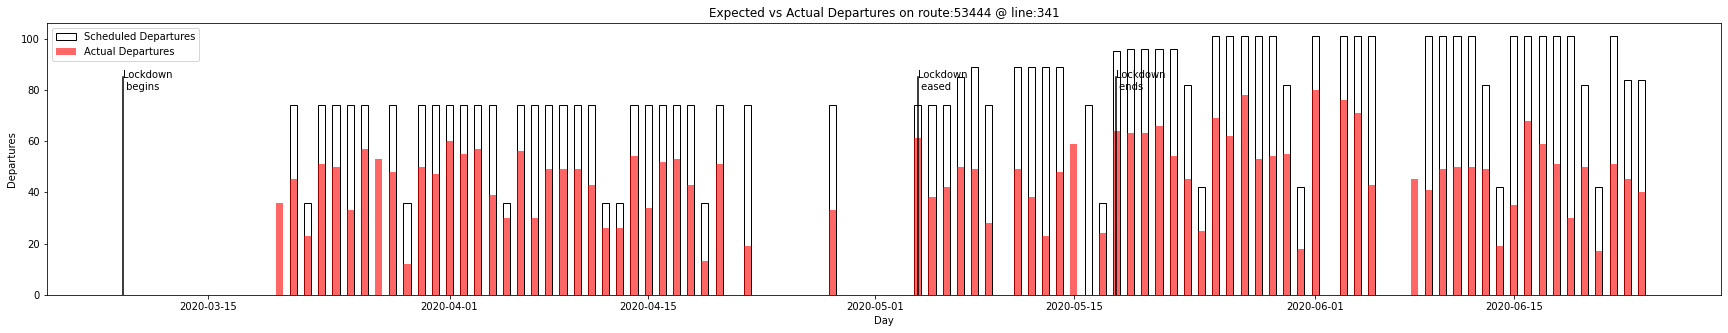

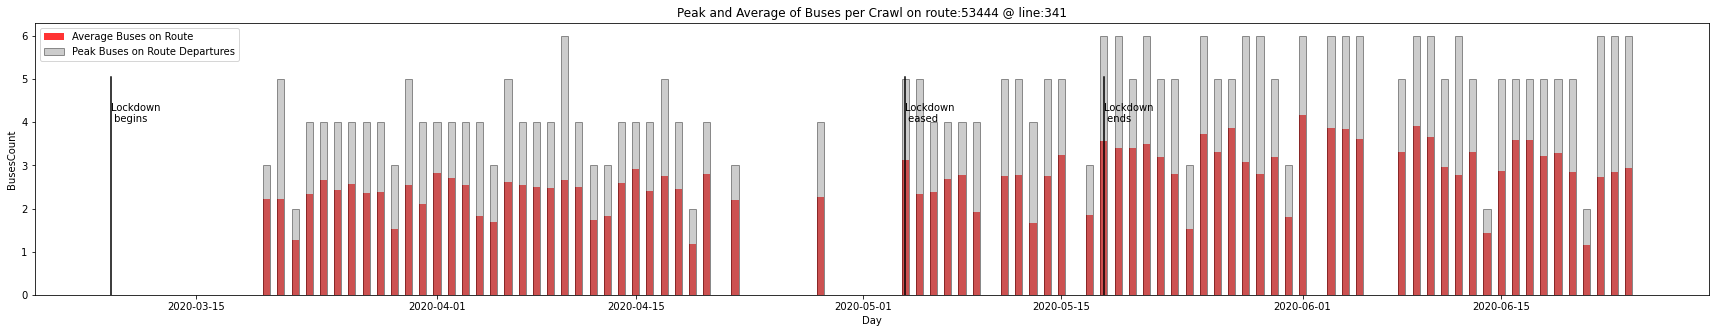

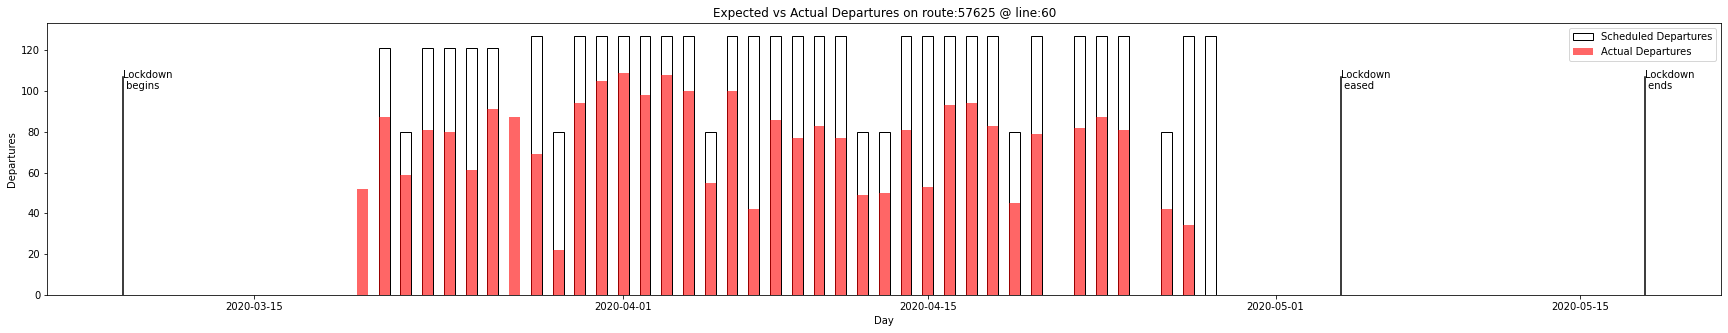

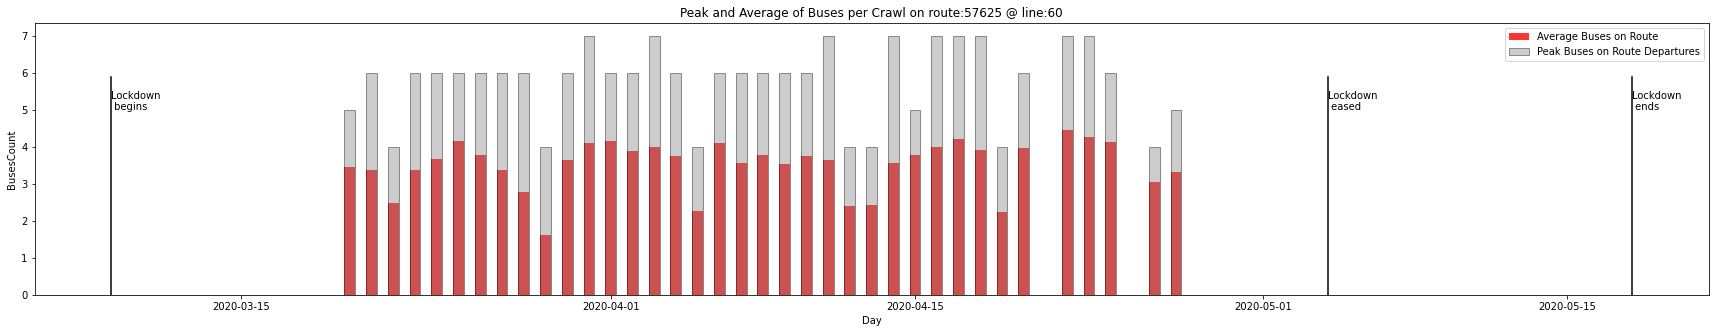

In [ ]:
session.rollback()


for line_id in ['88','337', '14', '341', '60']:
  for route_id in session.query(distinct(RouteStop.route_id)).filter(RouteStop.line_id == line_id).all():
    plot_departures(line_id, route_id[0], True)
    plot_avg_buses(line_id, route_id[0], True)
    plot_avg_traffic(line_id, route_id[0], True)
    break